# Превращаем людей в белых ходоков и обратно


Работа фаната Игры Престолов: что было бы, если в детсятве героев их младенцами забрали белые ходоки? Как бы они выглядели? А как бы выглядили сами ходоки, если бы их судьба сложилась по-другому?
Сейчас узнаем.

Для начала установим и импортируем нужные нам библиотеки:

In [0]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1

In [0]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Получаем датасеты

Здесь пришлось повозиться, но в итоге - вот что у меня получилось. Потом решила, что можно уже здесь архив распаковывать, но и эта реализация имеет право на существование, в целом - без разницы.

Чтобы запустить ноутбук не вникая в смысл путей к файлам и тд - дальше будут некоторые комментарии по поводу путей к файлам

In [0]:
from google.colab import drive  #чтобы получить доступ к файлам на нашем гугл диске
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Здесь тоже нужно авторизироваться, это нужно, чтобы получить список файлов (картинок) в конкретной папке

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
     os.makedirs(local_download_path)
except: pass



Вот тут внимательно:


1.   Открываете папку hodocs на google drive.
2.   Вверху, в качестве ссылки видите что-то вроде https://drive.google.com/drive/folders/1nVCY_S_SCJSffvXhg-HNd0jy2RNOuGFb, та часть, которая после folders/ нам и нужна.
3.   Прописываем эту часть пути к файлам в одинарных ковычках у file_list_h
4. Эту же операцию повторяем с папкой people и file_list_p



In [0]:
file_list_h = drive.ListFile(
       {'q': "'1nVCY_S_SCJSffvXhg-HNd0jy2RNOuGFb' in parents"}).GetList()

file_list_p = drive.ListFile(
       {'q': "'1hyMLRCOA2ISuaOrmEcu_2eJP3xNFMJiy' in parents"}).GetList()

In [0]:
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ColorJitter(brightness=(0.75,1.25), contrast=(0.75,1.25), saturation=0, hue=(0.75,1.25)), # так как датасеты очень небольшие, так как у ходоков, к сожалению, мало 
    transforms.CenterCrop(imsize),                                                                       # экранного времени, то делаем ауги=ментацию
    transforms.ToTensor()]) 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # переносим вычисления и данные на gpu
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')   # есть png картинки, поэтому приходится приводить к RGB
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [0]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


In [0]:
from torch.utils.data import DataLoader
batch_size = 25   # определим размер батчей

In [0]:
# Эта ячейка работает если папки hodocs и people лежат в корневом каталоге. Если возникает ошибка - поменяйте ваши пути к папкам
hodocs=[]
for img in file_list_h:
  fname = os.path.join(local_download_path, img['title']).split("/")[-1]
  style_img = image_loader("gdrive/My Drive/hodocs/"+fname)
  hodocs.append(style_img)

people=[]
for img in file_list_p:
  fname = os.path.join(local_download_path, img['title']).split("/")[-1]
  style_img = image_loader("gdrive/My Drive/people/"+fname)
  people.append(style_img)


In [0]:
hodocs_loader = DataLoader(hodocs, batch_size=batch_size, shuffle=True)
people_loader = DataLoader(people, batch_size=batch_size, shuffle=True)

Итак, наши изображения получены. Приступаем к самому интересному.

# Модели для CycleGAN

In [0]:
from torch import nn
import torch
from torch.nn import functional as F
import functools
import itertools

In [0]:
class NLayerDiscriminator(nn.Module):
    def __init__(self):
        super(NLayerDiscriminator, self).__init__()
        self.dis_model = nn.Sequential(
                     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
                     nn.LeakyReLU(0.2, True),

                     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(128),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(256),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
                     nn.BatchNorm2d(512),
                     nn.LeakyReLU(0.2,True),

                     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

        )
        

    def forward(self, input):
        res=self.dis_model(input)
        return res

In [0]:
class UnetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.pool0 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1,stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool1 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1,stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool2 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1,stride=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.pool3 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256,out_channels=256,kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=512,out_channels=128,kernel_size=3,padding=1)
        self.upsample1 = nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=256,out_channels=64,kernel_size=3,padding=1)
        self.upsample2 = nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=128,out_channels=32,kernel_size=3,padding=1)
        self.upsample3 = nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,padding=1)

    def forward(self, x):
        # encoder
        c0 = F.leaky_relu(self.enc_conv0(x),0.02)
        e0 = self.pool0(c0)
        c1 = F.leaky_relu(self.enc_conv1(e0),0.02)
        e1 = self.pool1(c1)
        c2 = F.leaky_relu(self.enc_conv2(e1),0.02)
        e2 = self.pool2(c2)
        c3 = F.leaky_relu(self.enc_conv3(e2),0.02)
        e3 = self.pool3(c3)

        # bottleneck
        cb=F.leaky_relu(self.bottleneck_conv(e3),0.02)
        b = self.upsample0(cb)

        # decoder
        conc0 = torch.cat([b, c3],dim=1)
        d0 = self.upsample1(F.leaky_relu(self.dec_conv0(conc0),0.02))
        conc1 = torch.cat([d0, c2],dim=1)
        d1 = self.upsample2(F.leaky_relu(self.dec_conv1(conc1),0.02))
        conc2 = torch.cat([d1, c1],dim=1)
        d2 = self.upsample3(F.leaky_relu(self.dec_conv2(conc2),0.02))
        conc3 = torch.cat([d2, c0],dim=1)
        d3 = self.dec_conv3(conc3)  # no activation
        return d3


Эта штука нам понадобится, когда будем обучать дискриминаторы, чтобы ипользовать ранее сгенерированные изображения

In [0]:
class Sample_from_Pool(object):
    def __init__(self):
        self.max_elements = 50
        self.cur_elements = 0
        self.items = []

    def __call__(self, in_items):
        return_items = []
        for in_item in in_items:
            if self.cur_elements < self.max_elements:
                self.items.append(in_item)
                self.cur_elements = self.cur_elements + 1
                return_items.append(in_item)
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_elements)
                    tmp = copy.copy(self.items[idx])
                    self.items[idx] = in_item
                    return_items.append(tmp)
                else:
                    return_items.append(in_item)
        return return_items

# Вишенка на торте - функция обучения модели.

In [0]:
from torch.autograd import Variable
from torch.optim import lr_scheduler

In [0]:
def train(genA,genB,discA,discB,a_loader,b_loader,optimaizerG,optimaizerD,schedulerG,shedulerD,mse,l1,epochs=100,lamda=10,idt_coef=0.5):

    a_fake_sample = Sample_from_Pool()
    b_fake_sample = Sample_from_Pool()

    # Для графиков
    discA_losses_total=[]
    discB_losses_total=[]
    gen_losses_total=[]

    for epoch in range(epochs):
        discA_losses=[]
        discB_losses=[]
        gen_losses=[]
        print('* Epoch %d/%d' % (epoch+1, epochs))
        for i, (a_real, b_real) in enumerate(zip(a_loader, b_loader)):

                # Временно мы не обучаем дискриминаторы, банкир ещё не видел монеты, пусть сначала их придумает фальшивомонетчик
                for param in discA.parameters():
                    param.requires_grad = False
                for param in discB.parameters():
                    param.requires_grad = False

                # Зануляем
                optimaizerG.zero_grad()

                a_real = Variable(a_real[0])
                b_real = Variable(b_real[0])
                a_real, b_real = a_real.to(device), b_real.to(device)

                # Сгенерируем фальшивых ходока и человека
                a_fake = genA(b_real)
                b_fake = genB(a_real)

                # И попытаеся восстановить оригиналы
                a_recon = genA(b_fake)
                b_recon = genB(a_fake)

                # А так же сделаем ходока из ходока и человека из человека
                a_idt = genA(a_real)
                b_idt = genB(b_real)

                # Посчитаем лосс, насколько новаторскими они получились
                a_idt_loss = l1(a_idt, a_real) * lamda * idt_coef
                b_idt_loss = l1(b_idt, b_real) * lamda * idt_coef

                # Посмотрим, примут ли наши дискриминаторы сгенерированных ходока и человека за настоящих
                a_fake_dis = discA(a_fake)
                b_fake_dis = discB(b_fake)

                # Посмотрим, насколько хорошо подделывют ходоков и людей генераторы
                real_label = Variable(torch.ones(a_fake_dis.size())).to(device)
                a_gen_loss = mse(a_fake_dis, real_label)
                b_gen_loss = mse(b_fake_dis, real_label)

                # И посчитаем потери па полном обороте, между изначальной картинкой и восстановленной из генерированной
                a_cycle_loss = l1(a_recon, a_real) * lamda
                b_cycle_loss = l1(b_recon, b_real) * lamda

                # Общий лосс будет считаться как сумма
                gen_loss = a_gen_loss + b_gen_loss + a_cycle_loss + b_cycle_loss + a_idt_loss + b_idt_loss
                gen_losses.append(gen_loss) # Это нам понадобится для графиков

                # Улучшим модели
                gen_loss.backward()
                optimaizerG.step()

                # Теперь проведём серьёзную беседу с дискриминаторами, для начала разморозим веса, иначе так и не научатся
                for param in discA.parameters():
                    param.requires_grad = True
                for param in discB.parameters():
                    param.requires_grad = True

                # Зануляем
                optimaizerD.zero_grad()

                # Глянем на уже сгенерированные ранее изображения
                a_fake = Variable(torch.Tensor(a_fake_sample([a_fake.cpu().data.numpy()])[0]))
                b_fake = Variable(torch.Tensor(b_fake_sample([b_fake.cpu().data.numpy()])[0]))
                a_fake, b_fake = a_fake.to(device),b_fake.to(device)

                # Посмотрим, как дискриминаторы распознают изображения и зададим, что все фейковые - фейк (0), а настоящие - настоящие (1)
                a_real_dis = discA(a_real)
                a_fake_dis = discA(a_fake)
                b_real_dis = discB(b_real)
                b_fake_dis = discB(b_fake)
                real_label = Variable(torch.ones(a_real_dis.size())).to(device)
                fake_label = Variable(torch.zeros(a_fake_dis.size())).to(device)

                # Посчитаем MSELoss
                a_dis_real_loss = mse(a_real_dis, real_label)
                a_dis_fake_loss = mse(a_fake_dis, fake_label)
                b_dis_real_loss = mse(b_real_dis, real_label)
                b_dis_fake_loss = mse(b_fake_dis, fake_label)

                # Считаем общий лосс каждого из дискриминаторов
                a_dis_loss = (a_dis_real_loss + a_dis_fake_loss)*0.5
                b_dis_loss = (b_dis_real_loss + b_dis_fake_loss)*0.5
                discA_losses.append(a_dis_loss)
                discB_losses.append(b_dis_loss)

                # Оптимизируем!
                a_dis_loss.backward()
                b_dis_loss.backward()
                optimaizerD.step()

                # Секундочку на реализацию красивого вывода
                print("Epoch: (%3d) (%5d/%5d) | Gen Loss:%.2e | Dis Loss:%.2e" % 
                                            (epoch+1, i + 1, min(len(a_loader), len(b_loader)),
                                                            gen_loss,a_dis_loss+b_dis_loss))

                # Меняем шедулеры
                schedulerG.step()
                schedulerD.step()

        # После того, как сеть трагично вылетела после 12 часов вобучения и добавила эти строки, они появились после осознания того, что всё тлен, и от того особенно важны
        if (epoch+1)%10==0:
                  # сохранить веса нашей нейросети model
                  torch.save(genA.state_dict(), "gdrive/My Drive/leaky_got_genA"+str(epoch+1)+".pth")
                  torch.save(genB.state_dict(), "gdrive/My Drive/leaky_got_genB"+str(epoch+1)+".pth")
                  torch.save(discA.state_dict(), "gdrive/My Drive/leaky_got_discA"+str(epoch+1)+".pth")
                  torch.save(discB.state_dict(), "gdrive/My Drive/leaky_got_discB"+str(epoch+1)+".pth") 


        #И да, нам ведь нужны красивые графики
        gen_losses_total.append(torch.mean(torch.Tensor(gen_losses)))
        discA_losses_total.append(torch.mean(torch.Tensor(discA_losses)))  
        discB_losses_total.append(torch.mean(torch.Tensor(discB_losses)))  
        
    return gen_losses_total, discA_losses_total, discB_losses_total





# Ну и самое прекрасное: процесс обучения

In [0]:
import numpy as np

In [0]:
epochs=40

# Зададим сами сети
genA = UnetGenerator()
genB = UnetGenerator()
discA = NLayerDiscriminator()
discB = NLayerDiscriminator()

# Оптимизаторы
optimaizerG = torch.optim.Adam(itertools.chain(genA.parameters(),genB.parameters()), lr=.0002, betas=(0.5, 0.999))
optimaizerD = torch.optim.Adam(itertools.chain(discA.parameters(),discB.parameters()), lr=.0002, betas=(0.5, 0.999))

# Шедулеры
schedulerG = torch.optim.lr_scheduler.StepLR(optimaizerG, 40, 0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimaizerD, 40, 0.5)

# Функции потерь
mse = nn.MSELoss()
l1 = nn.L1Loss()

In [0]:
gen_losses, discA_losses, discB_losses=train(genA,genB,discA,discB,people_loader,hodocs_loader,optimaizerG,optimaizerD,schedulerG,schedulerD,mse,l1,epochs=epochs)

* Epoch 1/40
Epoch: (  1) (    1/    6) | Gen Loss:1.87e+01 | Dis Loss:1.28e+00
Epoch: (  1) (    2/    6) | Gen Loss:1.30e+01 | Dis Loss:5.07e+00
Epoch: (  1) (    3/    6) | Gen Loss:1.27e+01 | Dis Loss:2.88e+00
Epoch: (  1) (    4/    6) | Gen Loss:1.28e+01 | Dis Loss:2.38e+00
Epoch: (  1) (    5/    6) | Gen Loss:9.18e+00 | Dis Loss:6.46e-01
Epoch: (  1) (    6/    6) | Gen Loss:1.04e+01 | Dis Loss:8.31e-01
* Epoch 2/40
Epoch: (  2) (    1/    6) | Gen Loss:1.14e+01 | Dis Loss:8.03e-01
Epoch: (  2) (    2/    6) | Gen Loss:1.06e+01 | Dis Loss:5.80e-01
Epoch: (  2) (    3/    6) | Gen Loss:5.82e+00 | Dis Loss:3.62e-01
Epoch: (  2) (    4/    6) | Gen Loss:1.37e+01 | Dis Loss:3.37e-01
Epoch: (  2) (    5/    6) | Gen Loss:1.68e+01 | Dis Loss:3.23e-01
Epoch: (  2) (    6/    6) | Gen Loss:4.72e+00 | Dis Loss:5.34e-01
* Epoch 3/40
Epoch: (  3) (    1/    6) | Gen Loss:1.04e+01 | Dis Loss:3.40e-01
Epoch: (  3) (    2/    6) | Gen Loss:7.30e+00 | Dis Loss:3.92e-01
Epoch: (  3) (    3/   

Посмотрим на прекрасный график

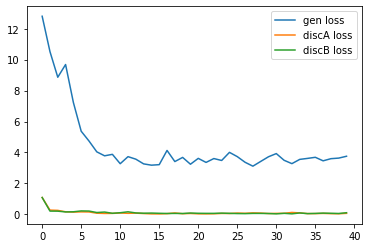

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(len(gen_losses)), gen_losses, label='gen loss')
plt.plot(range(len(discA_losses)), discA_losses, label='discA loss')
plt.plot(range(len(discB_losses)), discB_losses, label='discB loss')
plt.legend()
plt.show()

Ну и, наконец, получим результат

In [0]:
a_real_test = Variable(iter(people_loader).next()[0], requires_grad=True)
b_real_test = Variable(iter(hodocs_loader).next()[0], requires_grad=True)
a_real_test, b_real_test = a_real_test.to(device), b_real_test.to(device)
        

genA.eval()
genB.eval()

with torch.no_grad():
    a_fake_test = genA(b_real_test)
    b_fake_test = genB(a_real_test)
    a_recon_test = genA(b_fake_test)
    b_recon_test = genB(a_fake_test)

pic = (torch.cat([a_real_test, b_fake_test, a_recon_test, b_real_test, a_fake_test, b_recon_test], dim=0).data+0.5) / 2.0



In [0]:
import torchvision

Можете создать отдельную папку p2h_results и сохранить туда

In [0]:
torchvision.utils.save_image(pic, 'gdrive/My Drive/p2h_results/leaky_got_aug_unet_sample_result'+str(epochs)+'.jpg', nrow=3)

Или просто к корневую

In [0]:
torchvision.utils.save_image(pic, 'gdrive/My Drive/leaky_got_aug_unet_sample_result'+str(epochs)+'.jpg', nrow=3)

# Фанатам Игры Престолов посвещается

Ну и в завершение скажу, что пока сеть работает не идельно, но проблема лишь в небольшом датасетею При его расширении результат будет гораздо круче. Поэтому всех фанатов игры престолов призываю стать контрибьютерами)
Уже охвачены - все подходящие картинки из гугла и серия 8 сезона, где происходит битва с ходоками. Всем желающим пересмтореть шедевр и пособирать скриншоты для этого проекта буду рада!